In [4]:
# Libraries:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from toolbox.auxiliary_functions import SRT_simulation, D_CODE_simulation, set_param_freq

# Seed:
np.random.seed(999)

#### Case $\mu$, $A$ fixed and $\omega$ varying
Consider the modified Van der Pol system with a nonlinear forcing term
$$
\begin{cases}
\dot{x}_0 = \mu x_0 - x_1 - \mu x_0 x_1^2 + A\sin(\omega x_1^2) \\
\dot{x}_1 = x_0
\end{cases}
$$
and with $\mu=1$, $A=1$ fixed, and $\omega \in [1,\pi]$.

In [5]:
# Select ODE & settings:
ode_name = 'OscilVdpODE_par_w' # help="name of the ode", type=str
ode_param = None # '1.,1.,1.' # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_ratio = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 103 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 1
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [ ]:
# running SR-T:
building_blocks_lambda0, function_names0 = SRT_simulation(ode_name, ode_param, 0, freq, n_sample, noise_ratio, alg='tv', seed=seed, n_seed=n_seed, T=T)
building_blocks_lambda1, function_names1 = SRT_simulation(ode_name, ode_param, 1, freq, n_sample, noise_ratio, alg='tv', seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=OscilVdpODE_par_w, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=103, n_seed=1
Dataset shape:  (101, 50, 3)


KeyboardInterrupt: 

In [4]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import numpy as np

class SRModel:
    def __init__(self, f):
        self.f = f
    
    def simulate(self, x0, t, u):
        # se u è un array (n_samples, 1)
        u_fun = interp1d(t, u, axis=0, kind="cubic", fill_value="extrapolate")

        def rhs(ti, z):
            k = float(u_fun(ti))   # interpolazione CORRETTA
            return self.f(z, ti, k)

        sol = solve_ivp(rhs, [t[0], t[-1]], x0, t_eval=t, method="LSODA")
        return sol.y.T


    
f = lambda x,t,k: [
     x[0]*x[1]*(2.6919317252165063 - x[1]) - 2.75556066802557*x[0]*x[1] + x[0] - x[1] + 0.43466019304941722,
     x[0]
]
model = SRModel(f)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_traj(model, ode, freq, n_sample, init_high, init_low, dim_x=1, dim_k=1, title=None, T_aux=100):

    np.random.seed(666)
    dt = 1 / freq
    time_vector = np.arange(0, T_aux + dt, dt)
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # true trajectories:
    # Assumiamo che 'data' sia disponibile nell'ambiente
    dg_true = data.DataGenerator(ode, T_aux, freq, n_sample, noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        t = np.arange(0, T_aux, dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot, 1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :][:-dim_k], t=t[:T_plot], u=test_params)
        else:
            pred_0 = model.simulate(xt_true[0, i, :], t=t[:T_plot])
        pred_0_list.append(pred_0)

    xt_true = xt_true[:len(pred_0), :, :]
    time_vector = time_vector[:len(pred_0)]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2))
    pred_0_list = pred_0_list.squeeze()

    if n_sample == 1:
        if dim_x == 1:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(time_vector, pred_0_list, color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(time_vector, xt_true, color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(time_vector[0], xt_true[0], color='green', label=r'Start')
            ax.scatter(time_vector[-1], xt_true[-1], color='red', label=r'End')
            ax.set_xlabel(r'$t$')  # CORSIVO LAΤEΧ
            ax.set_ylabel(r'$x$')  # CORSIVO LAΤEΧ
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True)

        elif dim_x == 2:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 0], xt_true[:, 1],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 0][0], xt_true[:, 1][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 0][-1], xt_true[:, 1][-1], color='red', label=r'End')
            ax.set_xlabel(r'$x_1$')  # CORSIVO LAΤEΧ
            ax.set_ylabel(r'$x_2$')  # CORSIVO LAΤEΧ
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True)

        else:  # dim_x == 3
            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': '3d'})
            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1], pred_0_list[:, 2],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 0], xt_true[:, 1], xt_true[:, 2],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 0][0], xt_true[:, 1][0], xt_true[:, 2][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 0][-1], xt_true[:, 1][-1], xt_true[:, 2][-1], color='red', label=r'End')
            ax.set_xlabel(r'$x$')  # CORSIVO LAΤEΧ
            ax.set_ylabel(r'$y$')  # CORSIVO LAΤEΧ
            ax.set_zlabel(r'$z$')  # CORSIVO LAΤEΧ
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True)


from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

def evaluate_RMSE(model, ode, freq, n_sample, init_high, init_low, dim_k=1):
    # function computing the RMSE (and the MSE) of a given model: 

    np.random.seed(666)
    dt = 1 / freq
    TIME = min(ode.T, 100) 

    # true trajectories:
    dg_true = data.DataGenerator(ode, TIME, freq, n_sample, noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt
    #print(np.shape(xt_true))

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):

        correct_param = xt_true[0, i, -dim_k:]
        #print(np.shape(correct_param))

        t = np.arange(0,TIME,dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot,1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :][:-dim_k], t= t[:T_plot], u = test_params)
        else: # dim_k == 0
            pred_0 = model.simulate(xt_true[0, i, :], t= t[:T_plot])
        pred_0_list.append(pred_0)
    #print(np.shape(pred_0_list))


    xt_true = xt_true[:len(pred_0), :, :]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    #print(np.shape(xt_true)) #(151, 25, 2)
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2))
    pred_0_list = pred_0_list.squeeze()
    #print(np.shape(pred_0_list)) #(151, 25, 2)

    # RMSE:
    rmse_0_list = []
    mse_0_list = []
    for i in range(n_sample):
        rmse_0 = root_mean_squared_error(xt_true[:, i], pred_0_list[:,i]) 
        mse_0 = mean_squared_error(xt_true[:, i], pred_0_list[:,i])
        rmse_0_list.append(rmse_0)
        mse_0_list.append(mse_0)
    rmse_0 = np.mean(rmse_0_list)
    mse_0 = np.mean(mse_0_list)
    return rmse_0, mse_0

/tmp/ipykernel_11625/3242030471.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA
/tmp/ipykernel_11625/3242030471.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


SR_T Model RMSE:  0.9029338988068736


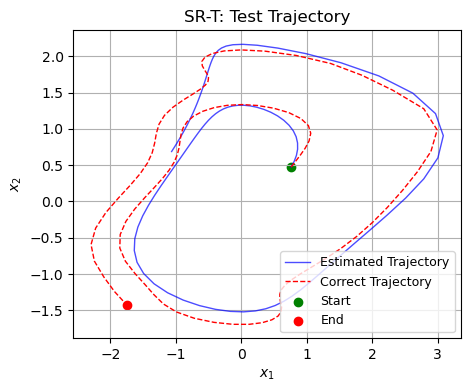

In [6]:
n_test = 10
rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_test, [1., 1., np.pi], [0., 0., 1.], dim_k)
print('SR_T Model RMSE: ', rmse)

evaluate_sample = 1
ics = [0.7, 0.4, 2.5]
title = 'SR-T: Test Trajectory'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=10)

/tmp/ipykernel_11625/3242030471.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


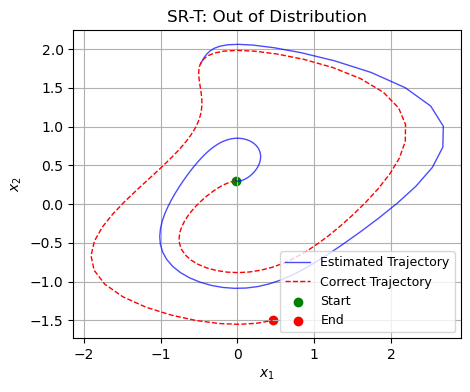

In [7]:
evaluate_sample = 1
ics = [0.0, 0.3, 0.8]
title = 'SR-T: Out of Distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=10)

/tmp/ipykernel_11625/3242030471.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


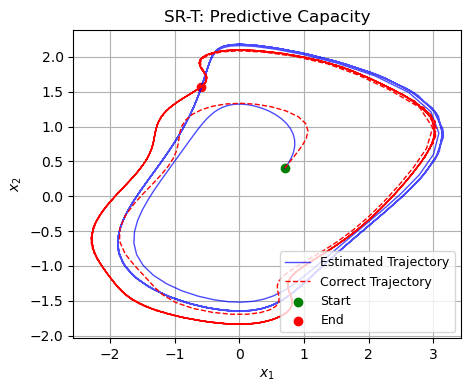

In [8]:
evaluate_sample = 1
ics = [0.7, 0.4, 2.5]
title = 'SR-T: Predictive Capacity'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=40)

In [ ]:
# running D-CODE
building_blocks_lambda0, function_names0 = D_CODE_simulation(ode_name, ode_param, 0, freq, n_sample, noise_ratio, seed=seed, n_seed=n_seed, T=T)
building_blocks_lambda1, function_names1 = D_CODE_simulation(ode_name, ode_param, 1, freq, n_sample, noise_ratio, seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=OscilVdpODE_par_w, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, seed=103, n_seed=1
Dataset shape:  (201, 50, 3)
Functions set:  {'neg': 1, 'mul': 2, 'add': 1, 'sub': 1, 'sin': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    14.66      3.60984e+10        9          191.505          207.464      4.57m
   1     9.00           186175       23          156.768          128.786      4.38m
   2     3.05          37522.9       23          150.703          183.372      3.36m
 
promising programs:
add(add(add(sub(X0, X1), sin(3.061)), mul(sub(3.325, X1), mul(X0, X1))), neg(mul(mul(1.378, X0), add(X1, X1))))
add(add(add(sub(X0, X1), sin(3.061)), mul(sub(3.325, X1), mul(X0, X1))), neg(mul(mul(1.378, X0), add(X1, X1))))
add(add(add(sub(X0, X1), sin(3.

In [7]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import numpy as np

class SRModel:
    def __init__(self, f):
        self.f = f
    
    def simulate(self, x0, t, u):
        # se u è un array (n_samples, 1)
        u_fun = interp1d(t, u, axis=0, kind="cubic", fill_value="extrapolate")

        def rhs(ti, z):
            k = float(u_fun(ti))   # interpolazione CORRETTA
            return self.f(z, ti, k)

        sol = solve_ivp(rhs, [t[0], t[-1]], x0, t_eval=t, method="LSODA")
        return sol.y.T


    
f = lambda x,t,k: [
    x[0]*x[1]*(3.3247875824471675 - x[1]) - 2.75556066802557*x[0]*x[1] - x[0]*np.sin(np.sin(x[1])) + x[0] - x[1] + np.sin(x[1]**2*k),
    x[0]
]
model = SRModel(f)



In [8]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_traj(model, ode, freq, n_sample, init_high, init_low, dim_x=1, dim_k=1, title=None, T_aux=100):

    np.random.seed(666)
    dt = 1 / freq
    time_vector = np.arange(0, T_aux + dt, dt)
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # true trajectories:
    # Assumiamo che 'data' sia disponibile nell'ambiente
    dg_true = data.DataGenerator(ode, T_aux, freq, n_sample, noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        t = np.arange(0, T_aux, dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot, 1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :][:-dim_k], t=t[:T_plot], u=test_params)
        else:
            pred_0 = model.simulate(xt_true[0, i, :], t=t[:T_plot])
        pred_0_list.append(pred_0)

    xt_true = xt_true[:len(pred_0), :, :]
    time_vector = time_vector[:len(pred_0)]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2))
    pred_0_list = pred_0_list.squeeze()

    if n_sample == 1:
        if dim_x == 1:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(time_vector, pred_0_list, color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(time_vector, xt_true, color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(time_vector[0], xt_true[0], color='green', label=r'Start')
            ax.scatter(time_vector[-1], xt_true[-1], color='red', label=r'End')
            ax.set_xlabel(r'$t$')  # CORSIVO LAΤEΧ
            ax.set_ylabel(r'$x$')  # CORSIVO LAΤEΧ
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True)

        elif dim_x == 2:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 0], xt_true[:, 1],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 0][0], xt_true[:, 1][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 0][-1], xt_true[:, 1][-1], color='red', label=r'End')
            ax.set_xlabel(r'$x_1$')  # CORSIVO LAΤEΧ
            ax.set_ylabel(r'$x_2$')  # CORSIVO LAΤEΧ
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True)

        else:  # dim_x == 3
            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': '3d'})
            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1], pred_0_list[:, 2],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 0], xt_true[:, 1], xt_true[:, 2],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 0][0], xt_true[:, 1][0], xt_true[:, 2][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 0][-1], xt_true[:, 1][-1], xt_true[:, 2][-1], color='red', label=r'End')
            ax.set_xlabel(r'$x$')  # CORSIVO LAΤEΧ
            ax.set_ylabel(r'$y$')  # CORSIVO LAΤEΧ
            ax.set_zlabel(r'$z$')  # CORSIVO LAΤEΧ
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True)


from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

def evaluate_RMSE(model, ode, freq, n_sample, init_high, init_low, dim_k=1):
    # function computing the RMSE (and the MSE) of a given model: 

    np.random.seed(666)
    dt = 1 / freq
    TIME = min(ode.T, 100) 

    # true trajectories:
    dg_true = data.DataGenerator(ode, TIME, freq, n_sample, noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt
    #print(np.shape(xt_true))

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):

        correct_param = xt_true[0, i, -dim_k:]
        #print(np.shape(correct_param))

        t = np.arange(0,TIME,dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot,1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :][:-dim_k], t= t[:T_plot], u = test_params)
        else: # dim_k == 0
            pred_0 = model.simulate(xt_true[0, i, :], t= t[:T_plot])
        pred_0_list.append(pred_0)
    #print(np.shape(pred_0_list))


    xt_true = xt_true[:len(pred_0), :, :]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    #print(np.shape(xt_true)) #(151, 25, 2)
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2))
    pred_0_list = pred_0_list.squeeze()
    #print(np.shape(pred_0_list)) #(151, 25, 2)

    # RMSE:
    rmse_0_list = []
    mse_0_list = []
    for i in range(n_sample):
        rmse_0 = root_mean_squared_error(xt_true[:, i], pred_0_list[:,i]) 
        mse_0 = mean_squared_error(xt_true[:, i], pred_0_list[:,i])
        rmse_0_list.append(rmse_0)
        mse_0_list.append(mse_0)
    rmse_0 = np.mean(rmse_0_list)
    mse_0 = np.mean(mse_0_list)
    return rmse_0, mse_0

/tmp/ipykernel_14002/1379217126.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA
/tmp/ipykernel_14002/1379217126.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


D-CODE Model RMSE:  0.4644006524973011


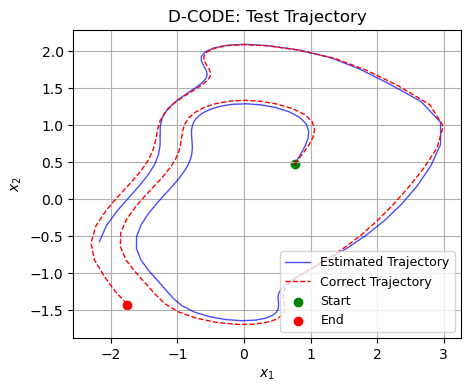

In [9]:
n_test = 10
rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_test, [1., 1., np.pi], [0., 0., 1], dim_k)
print('D-CODE Model RMSE: ', rmse)

evaluate_sample = 1
ics = [0.7, 0.4, 2.5]
title = 'D-CODE: Test Trajectory'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=10)

/tmp/ipykernel_14002/1379217126.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


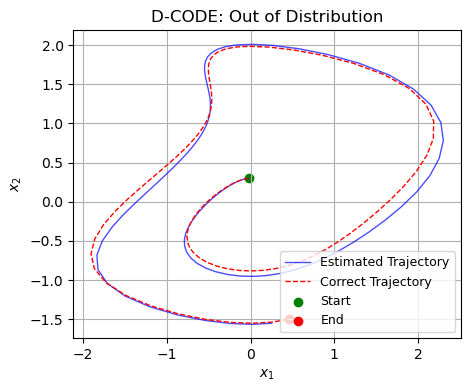

In [10]:
evaluate_sample = 1
ics = [0.0, 0.3, 0.8]
title = 'D-CODE: Out of Distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=10)

/tmp/ipykernel_14002/1379217126.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


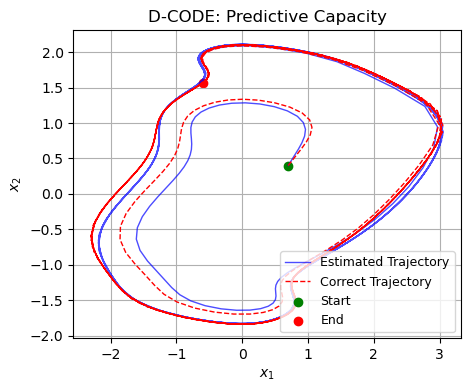

In [11]:
evaluate_sample = 1
ics = [0.7, 0.4, 2.5]
title = 'D-CODE: Predictive Capacity'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=40)